In [1044]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from custom_classes_and_functions import (recall_recall_product_score, ColumnDropper, 
                                          ColumnSelectorByType, MissingThresholdIndicator, 
                                          RareCategoriesMerger, SimpleImputerWrapper, 
                                          StandardScalerWrapper, VarianceThresholdWrapper)
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve, 
                             classification_report, make_scorer)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

from scipy.stats import uniform as sp_uniform

In [1059]:
pd.options.display.float_format = '{:20,.4f}'.format

RANDOM_STATE = 7532
N_CV_FOLDS = 5
np.random.seed(RANDOM_STATE)

Read in the data.

In [3]:
train_data = pd.read_csv('Data/train_data_raw.csv', low_memory=False)
test_data =  pd.read_csv('Data/test_data_raw.csv', low_memory=False)

with open('Data/data_dict.pkl', 'rb') as file:
    data_dict = pickle.loads(file.read())

with open('Data/dataframe_operations_02.pkl', 'rb') as file:
    dataframe_operations = pickle.loads(file.read())

In [4]:
data_dict = \
    data_dict.loc[~data_dict['column_name'].\
                  isin(dataframe_operations['columns_to_drop']), :]
data_dict = data_dict.reset_index(drop=True)

train_eda = train_data[data_dict['column_name']]

## Part I - Final Data Preparation and Pipeline Creation ##

Now, we collect the ideas pertaining to the feature engineering that came up during the exploratory phase and turn them into <br> a single function that we apply to our data.

In [5]:
def perform_feature_engineering(df):
    df = df.copy()
    # 1
    numerator = df['installment'] * df['term'].apply(lambda x: int(x[:3]))
    denominator = df['loan_amnt'] * (1 + df['int_rate']/100)
    df['ratio_1'] = numerator / denominator

    # 2    
    numerator = df['installment'] * df['term'].apply(lambda x: int(x[:3]))
    denominator = df['annual_inc'] + 1  # add 1 to safeguard against division by 0
    df['ratio_2'] = numerator / denominator
    
    # 3
    indx_null = df['emp_length'].isnull()
    df.loc[indx_null, 'emp_length'] = 'missing'

    def convert_emp_len(row):
        if row == 'missing':
            return 0
        elif row == '< 1 year':
            return 0.5
        elif row == '10+ years':
            return 10
        else:
            return int(row[0])

    df['emp_length'] = df['emp_length'].apply(convert_emp_len).astype(np.float)  
    
    # 4 
    df['descr_included'] = df['desc'].notnull().astype(np.int8).astype('object')

    # 5
    df['zip_1'] = df['zip_code'].apply(lambda x: int(x[:1])).astype('object')

    # 6
    df['ecl_month'] = df['earliest_cr_line'].apply(lambda x: x[:3])

    # 8
    df['ecl_year'] = df['earliest_cr_line'].apply(lambda x: int(x[4:]))

    index_1970 = df['ecl_year'] < 1970
    index_1980 = df['ecl_year'].between(1970, 1979)
    index_1990 = df['ecl_year'].between(1980, 1989)
    index_2000 = df['ecl_year'].between(1990, 1999)
    index_201x = df['ecl_year'] >= 2000

    df['ecl_period'] = df['ecl_year']
    df.loc[index_1970, 'ecl_period'] = "<1970"
    df.loc[index_1980, 'ecl_period'] = "1970-1979"
    df.loc[index_1990, 'ecl_period'] = "1980-1989"
    df.loc[index_2000, 'ecl_period'] = "1990-1999"
    df.loc[index_201x, 'ecl_period'] = ">=2000"

    df['ecl_year'] = df['ecl_year'] - 1945
    
    return df

In [6]:
train_data_enlarged = perform_feature_engineering(train_data)
test_data_enlarged = perform_feature_engineering(test_data)

We need to update information about the columns to be dropped as we no longer need those columns_to_enginner.

In [7]:
dataframe_operations['columns_to_drop'] += dataframe_operations['columns_to_engineer']
dataframe_operations['columns_to_engineer'] = []
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 56, 'columns_to_engineer': 0, 'rows_to_drop': 68}

Now, let's prepare our data for model training and testing and build a modeling pipeline.

In [8]:
rows_to_drop = dataframe_operations['rows_to_drop']

X_train = train_data_enlarged.drop(columns=['loan_status']).drop(index=rows_to_drop)
y_train = train_data_enlarged['loan_status'].drop(index=rows_to_drop)

X_test = test_data_enlarged.drop(columns=['loan_status'])
y_test = test_data_enlarged['loan_status']

In [9]:
num_subpipe = Pipeline([('num_selector_2', ColumnSelectorByType(np.number)), 
                        ('var_threshold', VarianceThreshold()), 
                        ('power_transf', PowerTransformer())
                       ])
cat_subpipe = Pipeline([('cat_selector_2', ColumnSelectorByType('category'))
                       ])

num_cat_submerger = FeatureUnion([('num_subpipeline', num_subpipe), 
                                  ('cat_subpipeline', cat_subpipe)
                                 ])

num_pipeline = Pipeline([('num_selector_1', ColumnSelectorByType(np.number)), 
                         ('num_missing_indicator', MissingThresholdIndicator(0.05)), 
                         ('num_imputer', SimpleImputerWrapper(strategy='mean')), 
                         ('num_cat_submerger', num_cat_submerger), 
                        ])

In [10]:
cat_pipeline = Pipeline([('cat_selector_1', ColumnSelectorByType('object')), 
                         ('cat_imputer', SimpleImputerWrapper(strategy='constant', 
                                                              fill_value='missing')), 
                         ('rare_cat_merger', RareCategoriesMerger(1500)), 
                         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', 
                                                           sparse=False))
                        ])

In [11]:
num_cat_merger = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline), 
                                                ('cat_pipeline', cat_pipeline)
                                               ])

columns_to_drop = list(set(dataframe_operations['columns_to_drop']))
preprocessing_pipeline = Pipeline([('column_dropper', ColumnDropper(columns_to_drop)), 
                                   ('num_cat_merger', num_cat_merger), 
                                   ('var_threshold', VarianceThreshold()), 
                                   ('std_scaler_1', StandardScaler()), 
                                   ('pca', PCA(n_components=0.99, svd_solver='full')), 
                                   ('std_scaler_2', StandardScaler()),                                    
                                  ])

## Part II - Model Training and Evaluation ## 

In [1035]:
#Helper functions and objects

def plot_precision_recall_curve(y_true, pred_prob, pos_label=1, figsize=(6, 6)):
    """
    Plots the precision-recall curve and returns precision and recall values 
    for various values of the threshold
    """
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, pred_prob, 
                                                             pos_label=pos_label)    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, precisions[:-1], color='b', label='Precision')
    plt.plot(thresholds, recalls[:-1], color='g', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.ylim([-0.01, 1.01])
    plt.show()
    
    return precisions, recalls


def plot_precision_vs_recall(precisions, recalls, figsize=(6, 6)):
    """
    Plots the precision versus recall curve
    """

    plt.figure(figsize=figsize)
    plt.plot(recalls, precisions, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()    
    
    return None


def roc_curve_and_auc_score(y_true, pred_prob, label='Classifier', figsize=(6, 6)):
    """
    Plots the ROC curve and computes the corresponding AUC score 
    incorporating it into the plot legend
    """
    
    fpr, tpr, _ = roc_curve(y_true, pred_prob)

    auc_score = np.round(roc_auc_score(y_true, pred_prob), 5)
    label += f',  AUC: {auc_score}'

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label)
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    return None


def cv_results(X, y, search_mode, estimator, parameters, scoring, 
               n_iter=16, cv=5, random_state=None, n_jobs=-1):
    """
    Performs either grid search or randomized search (depending on the search mode), 
    displays best score and parameters, and returns the fitted grid.
    If the grid search is selected, the parameters n_iter and random_state are ignored. 
    """
    
    if search_mode not in ['grid_search', 'randomized_search']:
        raise ValueError('Search mode should be either "grid_search or "randomized_search"')
        
    if search_mode == 'grid_search': 
        grid = GridSearchCV(estimator=estimator, param_grid=parameters, scoring=scoring, 
                            cv=cv, n_jobs=n_jobs)
    else: 
        grid = RandomizedSearchCV(estimator=estimator, param_distributions=parameters, 
                                  scoring=scoring, n_iter=n_iter, cv=cv, n_jobs=n_jobs, 
                                  random_state=random_state)        
    
    grid.fit(X, y)
    
    print(f'Best parameters:\n{grid.best_params_}')
    print()
    print(f'Best score: {grid.best_score_}')
    print()
    
    return grid


def model_results(y_true, y_pred, label='Model'):
    print(label + ' results:\n')

    print(f'Model Score: {recall_recall_product_score(y_true, y_pred)}\n')
    print(f'Confusion Matrix:\n{pd.crosstab(y_true, y_pred, colnames=["  prediction"])}\n')   
    print(f'Classification Report:\n{classification_report(y_true, y_pred)}\n')
    
    return None


# 5-fold splitter for the cross_validation
stratified_5_folds = StratifiedKFold(n_splits=N_CV_FOLDS, random_state=RANDOM_STATE)


# product of recalls for positive and negative class
my_scoring = make_scorer(recall_recall_product_score, greater_is_better=True)

**Logistic Regression**

In [678]:
LR_classifier = LogisticRegression(solver='saga', random_state=RANDOM_STATE)

LR_pipeline = Pipeline([('preprocessing_pipeline', preprocessing_pipeline), 
                        ('classifier', LR_classifier)])

LR_param_grid = {'classifier__C': [0.001, 0.005 ,0.01, 0.05, 0.1, 0.5, 1, 5], 
                 'classifier__penalty': ['l1', 'l2'], 
                 'classifier__class_weight': ['balanced']}

LR_param_distr = {'classifier__C': sp_uniform(0, 2), 
                  'classifier__penalty': ['l1', 'l2'], 
                  'classifier__class_weight': ['balanced']}

In [679]:
%%time
LR_grid = cv_results(X_train, y_train, search_mode='grid_search', estimator=LR_pipeline, 
                     parameters=LR_param_grid, scoring=my_scoring, n_iter=100, 
                     cv=stratified_5_folds.split(X_train, y_train))

Best parameters:
{'classifier__C': 0.005, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1'}

Best score: 0.41226687959949915

Wall time: 9min 35s


In [520]:
LR_train_preds = LR_grid.predict(X_train)
LR_y_train_prob = LR_grid.predict_proba(X_train)[:, 1]

In [1045]:
# Results on the train set might be overly optimistic due to overfitting
model_results(y_train, LR_train_preds, label='LR')

LR results:

Model Score: 0.420083510126637

Confusion Matrix:
  prediction       0      1
loan_status                
0             135383  72276
1              16091  29153

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75    207659
           1       0.29      0.64      0.40     45244

   micro avg       0.65      0.65      0.65    252903
   macro avg       0.59      0.65      0.58    252903
weighted avg       0.79      0.65      0.69    252903




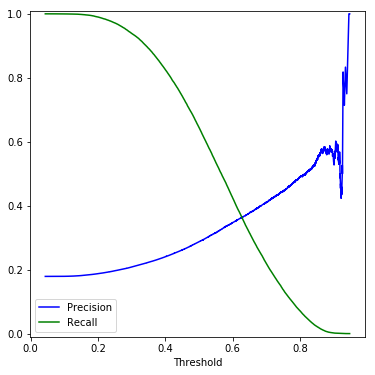

In [526]:
precisions, recalls = plot_precision_recall_curve(y_train, LR_y_train_prob, pos_label=1)

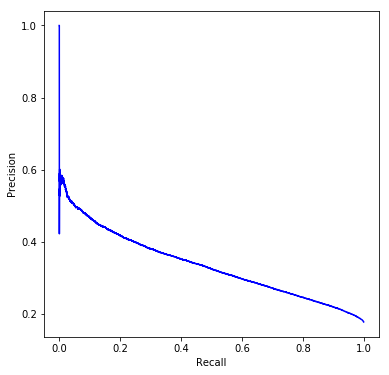

In [527]:
plot_precision_vs_recall(precisions, recalls)

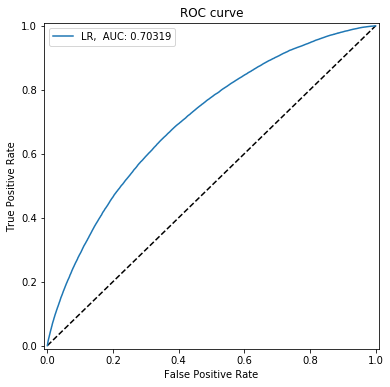

In [628]:
roc_curve_and_auc_score(y_train, LR_y_train_prob, label='LR')

**Linear SVM Classifier via SGD**

In [676]:
SVM_classifier = SGDClassifier(max_iter=1000, random_state=RANDOM_STATE)

SVM_pipeline = Pipeline([('preprocessing_pipeline', preprocessing_pipeline), 
                         ('classifier', SVM_classifier)])

SVM_param_grid = {'classifier__loss': ['hinge'], 
                  'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
                  'classifier__alpha': [0.04, 0.05, 0.06, 0.1, 0.5, 1, 5], 
                  'classifier__l1_ratio': [0.15, 0.30, 0.45, 0.60],
                  'classifier__class_weight': ['balanced']}

SVM_param_distr = {'classifier__loss': ['hinge'], 
                   'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
                   'classifier__alpha': sp_uniform(0, 0.1), 
                   'classifier__l1_ratio': sp_uniform(0, 0.3), 
                   'classifier__class_weight': ['balanced']}

In [677]:
%%time
SVM_grid = cv_results(X_train, y_train, search_mode='grid_search', estimator=SVM_pipeline, 
                      parameters=SVM_param_grid, scoring=my_scoring,  
                      cv=stratified_5_folds.split(X_train, y_train))

Best parameters:
{'classifier__alpha': 0.05, 'classifier__class_weight': 'balanced', 'classifier__l1_ratio': 0.15, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}

Best score: 0.41240563405046055

Wall time: 3h 10min 21s


In [547]:
SVM_train_preds = SVM_grid.predict(X_train)
SVM_y_train_prob = SVM_grid.decision_function(X_train)

In [1047]:
# Results on the train set might be overly optimistic due to overfitting
model_results(y_train, SVM_train_preds, label='SVM')

SVM results:

Model Score: 0.4205750568897157

Confusion Matrix:
  prediction       0      1
loan_status                
0             136440  71219
1              16283  28961

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    207659
           1       0.29      0.64      0.40     45244

   micro avg       0.65      0.65      0.65    252903
   macro avg       0.59      0.65      0.58    252903
weighted avg       0.79      0.65      0.69    252903




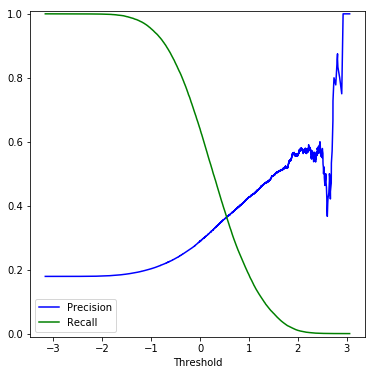

In [553]:
precisions, recalls = plot_precision_recall_curve(y_train, SVM_y_train_prob, pos_label=1)

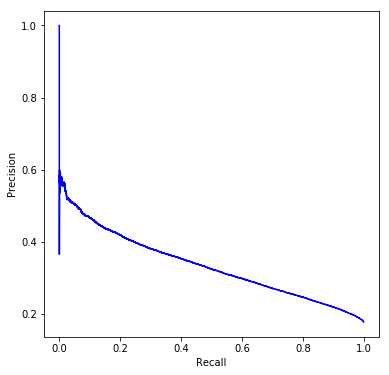

In [554]:
plot_precision_vs_recall(precisions, recalls)

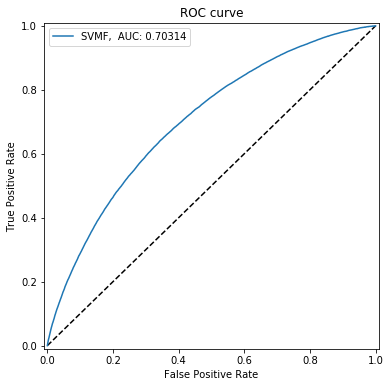

In [634]:
roc_curve_and_auc_score(y_train, SVM_y_train_prob, label='SVMF')

**Random Forest Classifier**

In [631]:
RF_classifier = RandomForestClassifier(random_state=RANDOM_STATE)

RF_pipeline = Pipeline([('preprocessing_pipeline', preprocessing_pipeline), 
                        ('classifier', RF_classifier)])

RF_param_grid = {'classifier__n_estimators': [101], 
                 'classifier__max_depth': [9, 10, 11], 
                 'classifier__min_samples_split': [100],
                 'classifier__min_samples_leaf': [50],
                 'classifier__max_features': [0.6, 0.7, 0.8],
                 'classifier__class_weight': ['balanced_subsample']}

In [632]:
%%time
RF_grid = cv_results(X_train, y_train, search_mode='grid_search', estimator=RF_pipeline, 
                     parameters=RF_param_grid, scoring=my_scoring, 
                     cv=stratified_5_folds.split(X_train, y_train))

Best parameters:
{'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 10, 'classifier__max_features': 0.7, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 100, 'classifier__n_estimators': 101}

Best score: 0.4018097322547649

Wall time: 2h 2min 31s


In [635]:
RF_train_preds = RF_grid.predict(X_train)
RF_y_train_prob = RF_grid.predict_proba(X_train)[:, 1]

In [1049]:
# Results on the train set might be overly optimistic due to overfitting
model_results(y_train, RF_train_preds, label='RF')

RF results:

Model Score: 0.4701994676203494

Confusion Matrix:
  prediction       0      1
loan_status                
0             148279  59380
1              15451  29793

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80    207659
           1       0.33      0.66      0.44     45244

   micro avg       0.70      0.70      0.70    252903
   macro avg       0.62      0.69      0.62    252903
weighted avg       0.80      0.70      0.73    252903




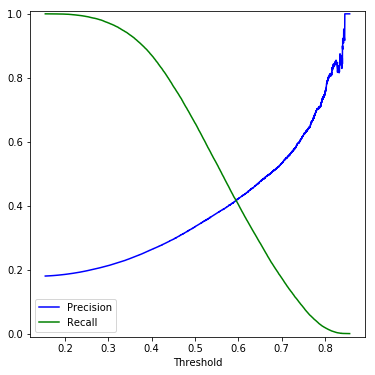

In [641]:
precisions, recalls = plot_precision_recall_curve(y_train, RF_y_train_prob, pos_label=1)

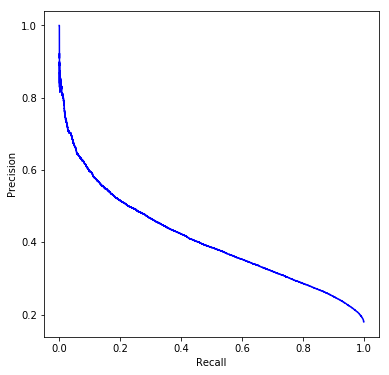

In [642]:
plot_precision_vs_recall(precisions, recalls)

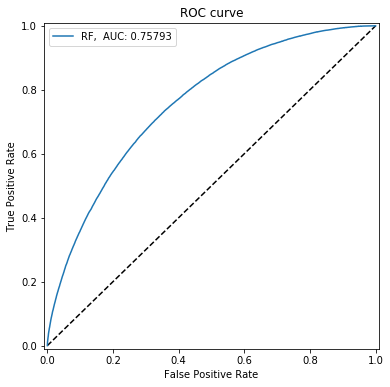

In [643]:
roc_curve_and_auc_score(y_train, RF_y_train_prob, label='RF')

The available feature importance information shows that the first 3 PCA features dominate the playing field.

In [644]:
RF_grid.best_estimator_.named_steps['classifier'].feature_importances_

array([0.17161529, 0.22124811, 0.11973817, 0.01076464, 0.06401973,
       0.00843508, 0.0616345 , 0.00661625, 0.00864147, 0.00640906,
       0.01223753, 0.00803703, 0.00580426, 0.00680953, 0.00588122,
       0.0065516 , 0.0042284 , 0.00395748, 0.00442522, 0.0047682 ,
       0.00420624, 0.0046457 , 0.00438411, 0.00423883, 0.00412216,
       0.00381344, 0.00442601, 0.00395657, 0.00438933, 0.00408882,
       0.00437824, 0.00485759, 0.0054432 , 0.00481733, 0.0051274 ,
       0.00638212, 0.00519593, 0.00591239, 0.00501605, 0.00416349,
       0.00567798, 0.0058282 , 0.00573377, 0.010499  , 0.00722502,
       0.00703465, 0.01715088, 0.00764202, 0.02091373, 0.02012073,
       0.00737408, 0.01080548, 0.0287339 , 0.00987287])

**XGBoost Classifier**

In [682]:
XGB_classifier = xgb.XGBClassifier(booster='gbtree', objective = 'binary:logistic', 
                                   random_state=RANDOM_STATE)

XGB_pipeline = Pipeline([('preprocessing_pipeline', preprocessing_pipeline), 
                         ('classifier', XGB_classifier)])

XGB_param_grid = {'classifier__n_estimators': [101], 
                  'classifier__max_depth': [4, 5, 6], 
                  'classifier__scale_pos_weight': [4.6],
                  'classifier__gamma': [0],
                  'classifier__reg_alpha': [0.75, 1], # was [1] - score 0.41683249
                  'classifier__reg_lambda': [1], 
                  'classifier__subsample': [0.5, 1], 
                  'classifier__colsample_bytree': [0.4, 0.5, 0.6], 
                  'classifier__colsample_bylevel': [0.5, 1]}

In [683]:
%%time
XGB_grid = cv_results(X_train, y_train, search_mode='grid_search', estimator=XGB_pipeline, 
                      parameters=XGB_param_grid, scoring=my_scoring, 
                      cv=stratified_5_folds.split(X_train, y_train))

Best parameters:
{'classifier__colsample_bylevel': 1, 'classifier__colsample_bytree': 0.5, 'classifier__gamma': 0, 'classifier__max_depth': 5, 'classifier__n_estimators': 101, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 1, 'classifier__scale_pos_weight': 4.6, 'classifier__subsample': 1}

Best score: 0.41683249183305643

Wall time: 2h 18min 50s


In [684]:
XGB_train_preds = XGB_grid.predict(X_train)
XGB_y_train_prob = XGB_grid.predict_proba(X_train)[:, 1]

In [1050]:
# Results on the train set might be overly optimistic due to overfitting
model_results(y_train, XGB_train_preds, label='XGB')

XGB results:

Model Score: 0.45079887569209653

Confusion Matrix:
  prediction       0      1
loan_status                
0             138177  69482
1              14592  30652

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77    207659
           1       0.31      0.68      0.42     45244

   micro avg       0.67      0.67      0.67    252903
   macro avg       0.61      0.67      0.59    252903
weighted avg       0.80      0.67      0.71    252903




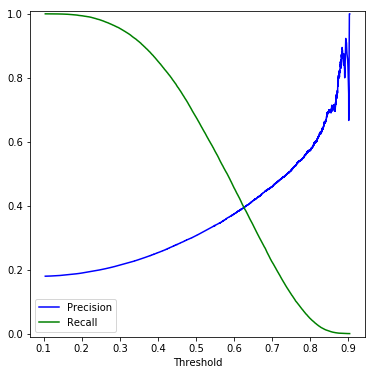

In [690]:
precisions, recalls = plot_precision_recall_curve(y_train, XGB_y_train_prob, pos_label=1)

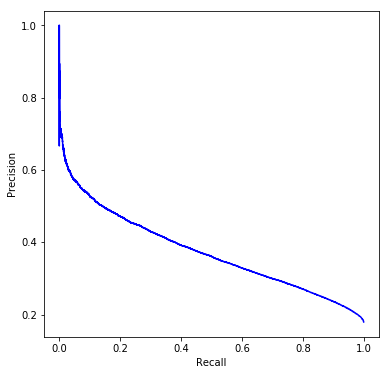

In [691]:
plot_precision_vs_recall(precisions, recalls)

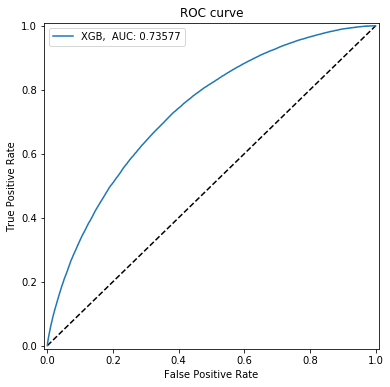

In [692]:
roc_curve_and_auc_score(y_train, XGB_y_train_prob, label='XGB')

**Soft Voting Classifier** 

We use the voting classifier provided by the sklearn package with voting set to 'soft' as, to quote the description, using this option allows the model to "predict the class label based on the argmax of the sums of the predicted probabilites." 

Unfortunately, SVM needs to be left out as it does not support probability computations.

In [664]:
classifier_list = [('LR', LR_classifier), ('RF', RF_classifier), ('XGB', XGB_classifier)]
voting_classifier = VotingClassifier(estimators=classifier_list, voting='soft')

voting_pipeline = Pipeline([('preprocessing_pipeline', preprocessing_pipeline), 
                            ('classifier', voting_classifier)])

voting_param_grid = {'classifier__LR__C': [0.005 , 1], 
                     'classifier__LR__penalty': ['l1', 'l2'], 
                     'classifier__LR__class_weight': ['balanced'],                      
                     'classifier__RF__n_estimators': [101], 
                     'classifier__RF__max_depth': [10, 15], 
                     'classifier__RF__min_samples_split': [100], 
                     'classifier__RF__min_samples_leaf': [50], 
                     'classifier__RF__max_features': [0.3, 0.7], 
                     'classifier__RF__class_weight': ['balanced_subsample'], 
                     'classifier__XGB__n_estimators': [101], 
                     'classifier__XGB__max_depth': [5, 10], 
                     'classifier__XGB__scale_pos_weight': [4.6], 
                     'classifier__XGB__gamma': [0], 
                     'classifier__XGB__reg_alpha': [0.1, 1], 
                     'classifier__XGB__reg_lambda': [0.1, 1], 
                     'classifier__XGB__subsample': [1], 
                     'classifier__XGB__colsample_bytree': [0.3, 0.5], 
                     'classifier__XGB__colsample_bylevel': [1]}

In [665]:
%%time
voting_grid = cv_results(X_train, y_train, search_mode='grid_search', 
                         estimator=voting_pipeline, parameters=voting_param_grid, 
                         scoring=my_scoring, cv=stratified_5_folds.split(X_train, y_train))

Best parameters:
{'classifier__LR__C': 1, 'classifier__LR__class_weight': 'balanced', 'classifier__LR__penalty': 'l1', 'classifier__RF__class_weight': 'balanced_subsample', 'classifier__RF__max_depth': 10, 'classifier__RF__max_features': 0.3, 'classifier__RF__min_samples_leaf': 50, 'classifier__RF__min_samples_split': 100, 'classifier__RF__n_estimators': 101, 'classifier__XGB__colsample_bylevel': 1, 'classifier__XGB__colsample_bytree': 0.5, 'classifier__XGB__gamma': 0, 'classifier__XGB__max_depth': 5, 'classifier__XGB__n_estimators': 101, 'classifier__XGB__reg_alpha': 0.1, 'classifier__XGB__reg_lambda': 1, 'classifier__XGB__scale_pos_weight': 4.6, 'classifier__XGB__subsample': 1}

Best score: 0.41590337447566667

Wall time: 2d 3h 29min 1s


In [666]:
voting_train_preds = voting_grid.predict(X_train)
voting_y_train_prob = voting_grid.predict_proba(X_train)[:, 1]

In [1053]:
# Results on the train set might be overly optimistic due to overfitting
model_results(y_train, voting_train_preds, label='Soft Voting')

Soft Voting results:

Model Score: 0.4466622772263207

Confusion Matrix:
  prediction       0      1
loan_status                
0             140531  67128
1              15382  29862

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77    207659
           1       0.31      0.66      0.42     45244

   micro avg       0.67      0.67      0.67    252903
   macro avg       0.60      0.67      0.60    252903
weighted avg       0.80      0.67      0.71    252903




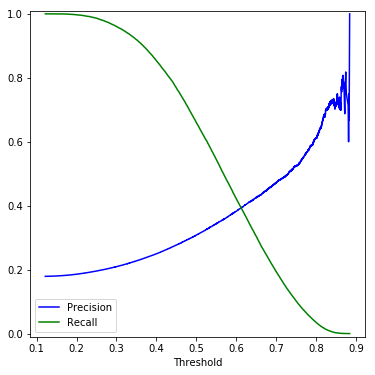

In [673]:
precisions, recalls = plot_precision_recall_curve(y_train, voting_y_train_prob, pos_label=1)

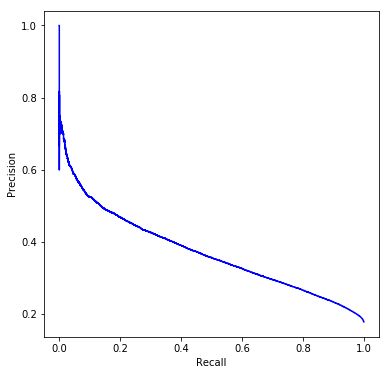

In [674]:
plot_precision_vs_recall(precisions, recalls)

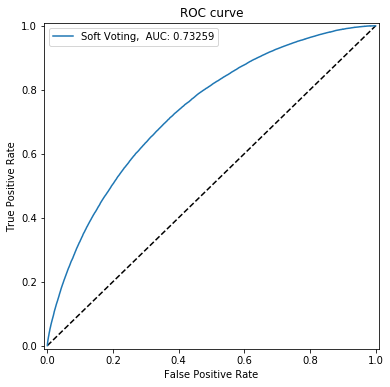

In [1054]:
roc_curve_and_auc_score(y_train, voting_y_train_prob, label='Soft Voting')

## Final Model Selection##

Let's collect and display each model's cross-validation scores.

In [1067]:
model_scores = [['LR', 'SVM', 'RF', 'XGB', 'Soft Voting'], 
                [LR_grid.best_score_, SVM_grid.best_score_, RF_grid.best_score_, 
                 XGB_grid.best_score_, voting_grid.best_score_]]

model_scores = pd.DataFrame(model_scores).T
model_scores.columns = ['Model', 'CV Score']
model_scores = model_scores.set_index('Model')
model_scores

,CV Score
Model,
LR,0.4123
SVM,0.4124
RF,0.4018
XGB,0.4168
Soft Voting,0.4159


Comparing the obtained cross-validation scores, we can see that among all of the considered models the XGB and Soft Voting models appear to be clearly the best, the LR and SVM models are not too far behind, while the RF model performs the worst. 

Therefore, we decide to choose the following weighted ensemble of the aforementioned models as our final model. 

In [1007]:
final_model = (2 * XGB_test_preds + \
               1 * LR_test_preds + \
               1 * SVM_test_preds + \
               1 * RF_test_preds + \
               2 * voting_test_preds > 1).astype(np.int8)

In [1036]:
model_results(y_test, final_model, label='Final Model')

Final Model results:

Model Score: 0.41342142842888335

Confusion Matrix:
  prediction      0      1
loan_status               
0             85409  45309
1             13661  23536

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.65      0.74    130718
           1       0.34      0.63      0.44     37197

   micro avg       0.65      0.65      0.65    167915
   macro avg       0.60      0.64      0.59    167915
weighted avg       0.75      0.65      0.68    167915




Comparison with the building blocks of the final model.

In [1039]:
model_results(y_test, LR_test_preds, label='LR')

LR results:

Model Score: 0.40114390384045695

Confusion Matrix:
  prediction      0      1
loan_status               
0             92449  38269
1             16099  21098

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77    130718
           1       0.36      0.57      0.44     37197

   micro avg       0.68      0.68      0.68    167915
   macro avg       0.60      0.64      0.60    167915
weighted avg       0.74      0.68      0.70    167915




In [1040]:
model_results(y_test, SVM_test_preds, label='SVM')

SVM results:

Model Score: 0.4011519341676483

Confusion Matrix:
  prediction      0      1
loan_status               
0             91902  38816
1             15973  21224

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77    130718
           1       0.35      0.57      0.44     37197

   micro avg       0.67      0.67      0.67    167915
   macro avg       0.60      0.64      0.60    167915
weighted avg       0.74      0.67      0.70    167915




In [1041]:
model_results(y_test, RF_test_preds, label='RF')

LR results:

Model Score: 0.40206198190705295

Confusion Matrix:
  prediction      0      1
loan_status               
0             87263  43455
1             14794  22403

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75    130718
           1       0.34      0.60      0.43     37197

   micro avg       0.65      0.65      0.65    167915
   macro avg       0.60      0.63      0.59    167915
weighted avg       0.74      0.65      0.68    167915




In [1042]:
model_results(y_test, XGB_test_preds, label='XGB')

LR results:

Model Score: 0.4095648114539003

Confusion Matrix:
  prediction      0      1
loan_status               
0             89318  41400
1             14901  22296

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76    130718
           1       0.35      0.60      0.44     37197

   micro avg       0.66      0.66      0.66    167915
   macro avg       0.60      0.64      0.60    167915
weighted avg       0.74      0.66      0.69    167915




In [1061]:
model_results(y_test, voting_test_preds, label='Soft Voting')

Soft Voting results:

Model Score: 0.40814204317995895

Confusion Matrix:
  prediction      0      1
loan_status               
0             90671  40047
1             15310  21887

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77    130718
           1       0.35      0.59      0.44     37197

   micro avg       0.67      0.67      0.67    167915
   macro avg       0.60      0.64      0.60    167915
weighted avg       0.74      0.67      0.69    167915


